In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = Image.open('mnist-sample-2.png').convert('L')
img_np = np.array(img) / 255.0

# Function to add Gaussian noise
def add_noise(image, noise_level):
    noise = np.random.normal(0, noise_level, image.shape)
    noisy_img = image + noise
    return np.clip(noisy_img, 0, 1)

# Images
img_clean = img_np
img_little_noise = add_noise(img_np, 0.5)
img_more_noise = add_noise(img_np, 2)
img_xt = np.random.normal(0.5, 0.5, img_np.shape)
img_xt = np.clip(img_xt, 0, 1)

# Save each
img_clean = Image.fromarray((img_clean * 255).astype(np.uint8))
img_little_noise = Image.fromarray((img_little_noise * 255).astype(np.uint8))
img_more_noise = Image.fromarray((img_more_noise * 255).astype(np.uint8))
img_xt = Image.fromarray((img_xt * 255).astype(np.uint8))

img_clean.save('mnist-sample-2-clean.png')
img_little_noise.save('mnist-sample-2-little-noise.png')
img_more_noise.save('mnist-sample-2-more-noise.png')
img_xt.save('mnist-sample-2-xT.png')

# Show images
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(img_clean, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(img_little_noise, cmap='gray')
axs[1].set_title('Little Noise')
axs[2].imshow(img_more_noise, cmap='gray')
axs[2].set_title('More Noise')
axs[3].imshow(img_xt, cmap='gray')
axs[3].set_title('x_T (Diffusion)')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'mnist-sample-2.png'

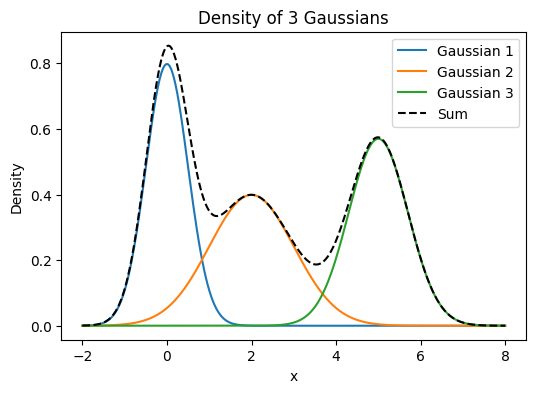

/tmp/ipykernel_2384437/3285687599.py:31: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_density_norm = total_density / np.trapz(total_density, x)
/tmp/ipykernel_2384437/3285687599.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mixed_density_norm = mixed_density / np.trapz(mixed_density, x)


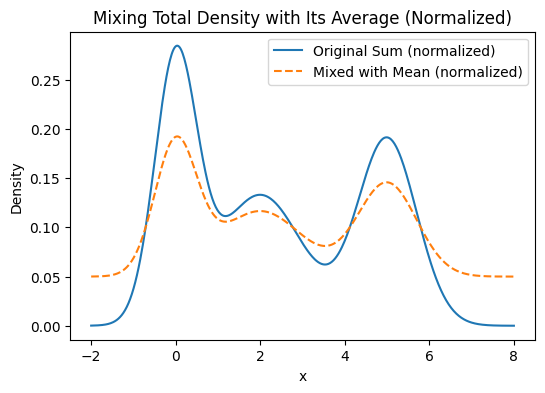

/tmp/ipykernel_2384437/3285687599.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mixed_density_norm = mixed_density / np.trapz(mixed_density, x)


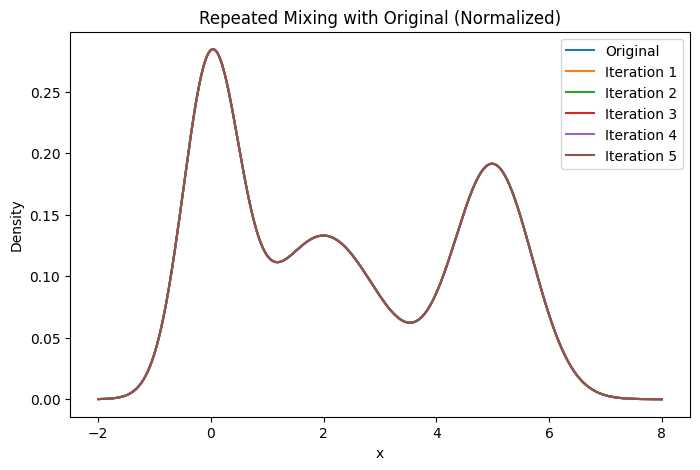

In [ ]:
import numpy as np

# Parameters for 3 Gaussians
means = [0, 2, 5]
stds = [0.5, 1.0, 0.7]
weights = [1, 1, 1]

x = np.linspace(-2, 8, 500)
densities = [w * (1/(s * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - m)/s)**2)
             for m, s, w in zip(means, stds, weights)]
total_density = np.sum(densities, axis=0)

plt.figure(figsize=(6, 4))
for i, d in enumerate(densities):
    plt.plot(x, d, label=f'Gaussian {i+1}')
plt.plot(x, total_density, 'k--', label='Sum')
plt.title('Density of 3 Gaussians')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()



# Mix total_density with its average (mean)
alpha = 0.5  # mixing coefficient
avg_density = np.mean(total_density)
mixed_density = alpha * total_density + (1 - alpha) * avg_density

# Normalize both densities so their area sums to 1
total_density_norm = total_density / np.trapz(total_density, x)
mixed_density_norm = mixed_density / np.trapz(mixed_density, x)

plt.figure(figsize=(6, 4))
plt.plot(x, total_density_norm, label='Original Sum (normalized)')
plt.plot(x, mixed_density_norm, label='Mixed with Mean (normalized)', linestyle='--')
plt.title('Mixing Total Density with Its Average (Normalized)')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

# Repeat the mixing and normalization 5 more times, but always mix with the original normalized distribution
densities_list = [total_density_norm]
for i in range(5):
    mixed_density = alpha * densities_list[-1] + (1 - alpha) * total_density_norm
    mixed_density_norm = mixed_density / np.trapz(mixed_density, x)
    densities_list.append(mixed_density_norm)

plt.figure(figsize=(8, 5))
for i, d in enumerate(densities_list):
    label = 'Original' if i == 0 else f'Iteration {i}'
    plt.plot(x, d, label=label)
plt.title('Repeated Mixing with Original (Normalized)')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for 3 Gaussian components in 2D
means = [np.array([2, 2]), np.array([-2, -2]), np.array([2, -2])]
covs = [np.eye(2) * 0.2, np.eye(2) * 0.3, np.eye(2) * 0.25]
n_samples = 10000

# Generate samples from the mixture
samples = np.vstack([
    np.random.multivariate_normal(mean, cov, n_samples)
    for mean, cov in zip(means, covs)
])

# DDPM noise schedule parameters
T = 30  # total diffusion steps
betas = np.linspace(0.01, 0.2, T)  # linear schedule
alphas = 1 - betas
alphas_bar = np.cumprod(alphas)

# Apply noise at each time step
noisy_samples = [samples]
for t in range(T):
    noise = np.random.randn(*samples.shape)
    x_t = np.sqrt(alphas_bar[t]) * samples + np.sqrt(1 - alphas_bar[t]) * noise
    noisy_samples.append(x_t)

# Create and save each density plot separately
step = 10
for t in range(0, T+1, step):
    # Create a new figure for each plot
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    
    data = noisy_samples[t]
    sns.kdeplot(
        x=data[:, 0], y=data[:, 1],
        fill=True, cmap='viridis', ax=ax,
        levels=50, thresh=0.05, bw_adjust=2.0,  # Smoother bandwidth and fewer levels
        alpha=0.95, linewidths=0.5  # Add smooth contour lines
    )
    ax.set_title(f"Step t={t}")
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Save each plot as a separate image
    fig.savefig(f"ddpm_density_step_{t}.png", bbox_inches='tight', pad_inches=0.1, dpi=150)
    plt.close(fig)  # Close the figure to free memory
    
print("Individual density plots saved successfully!")

/home/sage/repos/ddpm-manim/.venv/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/sage/repos/ddpm-manim/.venv/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
/home/sage/repos/ddpm-manim/.venv/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


Individual density plots saved successfully!


/home/sage/repos/ddpm-manim/.venv/lib/python3.11/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(
